In [5]:
import ipynb.fs.defs.Utils as utils
import numpy as np
import pandas as pd
import re
import math

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

#--------------------------------------------------------------------------------------------
# Settings
#--------------------------------------------------------------------------------------------
sns.set(font_scale=1.5)
sns.set_style("dark")

In [11]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

class DecisionTree:
  """ Decision tree model
  dataset : dictionary containing samples, features, and target variables
  
  plurality_value : checking the majority class of (sub)samples
  H               : computing the entropy 
  importance      : computing the feature importance (information gain)
  decision_tree_learning : decision tree learning from dataset
  fit             : model fitting to training dataset
  predict         : model prediction of testing dataset
  predict_error   : prediction error for model from given samples
  """

  def __init__(self, dataset, **kwargs):
    """
    Initialize model parameters
    """
    self.samples  = dataset['samples']
    self.target   = dataset['target']
    self.features = dataset['features']

    self.classes  = self.samples[self.target].unique()
    self.values   = {feature: self.samples[feature].unique() for feature in self.features}

    self.node_ctr = 0 # for plotting decision tree nodes
    self.hypothesis = Node(0) 

  def plurality_value(self, samples):
    """ 
    Plurality value function (AIMA Ch 18)

    Returns the class with majority of samples.
    In case of tie/s, return a random majority class.
    """
    # Randomly shuffle samples to break majority ties
    samples = samples.sample(frac=1, random_state=180)
    samples_target = samples[self.target] 
    major_class = None # either 'Yes' or 'No' for restaurant WillWait
    numyes = 0
    numno = 0

    for sample in samples_target:
    #print(sample)
        if sample == 'Yes':
          numyes = numyes+1
        elif sample == 'No':
          numno = numno + 1
    #print(numyes, numno)
    if(numyes>numno):
      major_class = 'Yes'
    elif(numno>numyes):
      major_class = 'No'
    else:
      major_class = samples_target.iloc[0]
    return major_class

  def H(self, samples):
    """
    Entropy function (AIMA Ch 18.3.4)

    Entropy is the number of bits required to describe the outcome of a random event.
    If H == 0, then we are always certain of the outcome, and thus require no bits.
    If H == 1, then we are uncertain of the outcome, and require 1 bit to describe the event.
    """
    target = self.target
    classes = self.classes
    entropy = 0

    # Computes the probabilities for each class
    sample_probabilities = {c: len(samples[samples[target] == c])/len(samples) for c in classes 
                              if len(samples[samples[target] == c])>0 and len(samples) > 0}

    for prob in sample_probabilities:
      #print(sample_probabilities[prob])
      entropy = entropy - sample_probabilities[prob]*math.log(sample_probabilities[prob], 2)
    #print(entropy)
    return entropy

  def importance(self, feature, samples):
    """
    Information gain function (AIMA Ch 18.3.4)

    Returns the information gain (reduction in entropy) when 
    splitting the samples by feature.

    Given feature F:
      Gain(F) = H(F) - Remainder(F)  
    """
    values = self.values
    H = self.H
    gain = -1

    n = len(samples)
    if n < 1: return 0

    # Choose samples with Feature = f   
    def choose(f):
      return samples[samples[feature]==f]

    remainder = 0
    for value in values[feature]:
      subsample = choose(value)
      remainder = remainder + len(subsample)/n*H(subsample)
      #print("remainder:", remainder)
    gain = H(samples) - remainder
    return gain

  def decision_tree_learning(self, samples, features, parent):
    """ 
    Algorithm for decision tree learning (AIMA Fig 18.5)

    Parameters
    - samples: remaining samples
    - features: remaining features
    - parent: tuple containing parent samples (for empty samples case),
              parent node (for tree), and parent label (for visualization)

    Returns
    - tree: current tree / subtree
    """
    self.node_ctr+=1
    target = self.target
    values = self.values
    
    # No more samples left -> get majority of parent samples
    if len(samples)==0:   
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target,
                                                self.plurality_value(parent['samples'])), 
                                                parent=parent['node'])

    # Final classification (leaf)
    elif (samples[target] == samples[target].iloc[0]).all():
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target, 
                                               self.plurality_value(samples)), 
                                               parent=parent['node'])

    # Mo more features left, but there are still samples -> get majority of samples
    elif len(features)==0:
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target, 
                                               self.plurality_value(samples)), 
                                               parent=parent['node'])

    # choose next feature branch  
    else:
      feature_importance = {feature: self.importance(feature, samples) for feature in features}
      best_feature = max(feature_importance, key=feature_importance.get)
      #bprint(feature_importance)
      if(parent['label']):
        tree = Node("[{0}] {1} | {2}".format(self.node_ctr, parent['label'], best_feature), 
                                             parent=parent['node'])

      else:
        self.node_ctr = 1
        tree = Node("[{0}] {1}".format(self.node_ctr, best_feature), parent=parent['node'])

      for value in sorted(values[best_feature]):        
        subfeatures = [x for x in features if x != best_feature]
        subsamples = samples[samples[best_feature]==value]
        subsamples = subsamples[subfeatures+[target]]
        subtree = self.decision_tree_learning(subsamples, subfeatures, 
                                             {'samples': samples, 'node': tree, 
                                             'label': "{0}={1}".format(best_feature, value)})
      return tree

  def fit(self):
    """
    Train the model with the given samples and features
    """  
    self.hypothesis = self.decision_tree_learning(self.samples, self.features, 
                                            parent={'samples': self.samples, 
                                                    'node': None, 'label': None})  
    
  def predict(self, sample):
    """
    Predict the classes of the test samples
    """
    tree = self.hypothesis
    raise NotImplementedError("Function [predict] not yet implemented")
  
  def predict_error(self, samples):
    """
    Returns the prediction error given the samples
    """
    raise NotImplementedError("Function [predict_error] not yet implemented")

In [12]:
df = pd.read_csv('../data/symptoms.csv')

# Set the feature and target variables
features = ['Runny nose','Cough','Sore throat','Body aches/pain','Fatigue','Congestion (sinuses or lungs)','Fever','Difficulty breathing','Headache','Chest Pain','Nosebleeds','Irregular heart rhythms','Vision changes','Buzzing of ears','Nausea','Vomiting','Bloating','Abdominal pain','Irregular stool','Prolonged diarrhea','Frequent urination or feeling of urinating','Bloody urine','Pain while urinating','Pressure or craming in groin','Weight loss','Night sweats','Loss of appetite','Neck swelling/pain','Dizziness','Heart attack','Palpitations']
target   = 'Diseases'

dataset_symptoms = {'samples'  : df[features+[target]],
                 'target'   : target,
                 'features' : features}

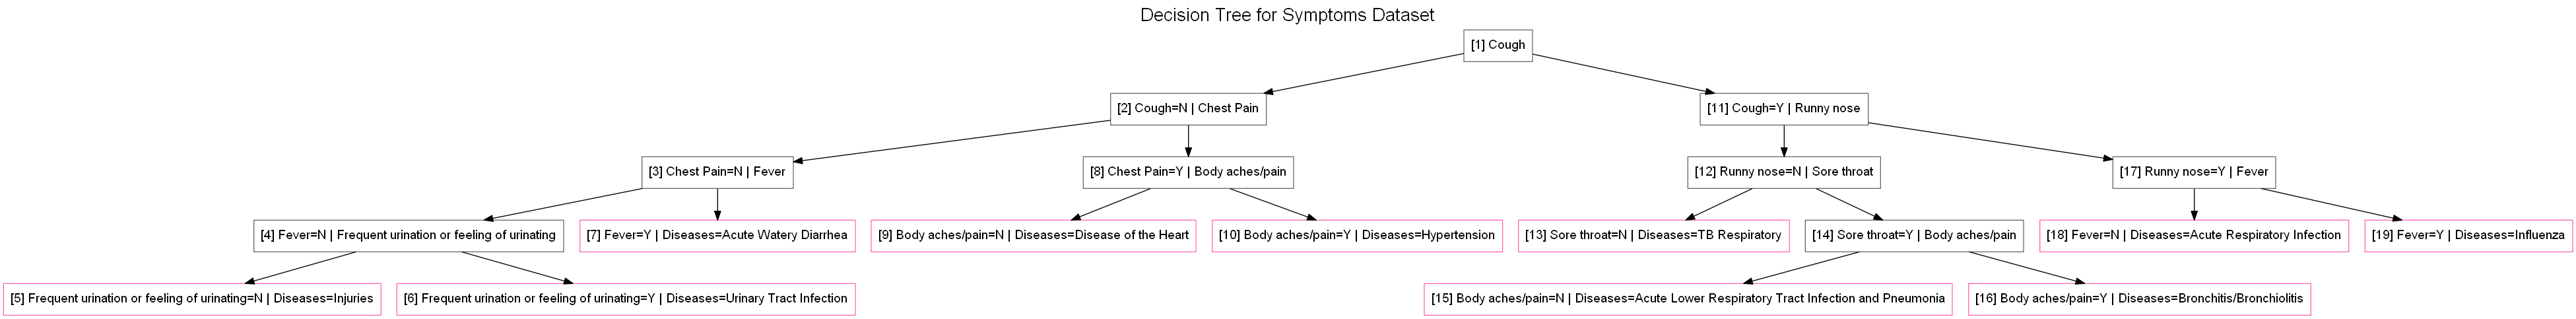

In [13]:
dtree_model = DecisionTree(dataset_symptoms)
dot_file = '../results/symptoms_dtree.dot'
img_file = '../results/symptoms_dtree.dot.png'
img_title = "Decision Tree for Symptoms Dataset"
dtree_model.fit()

# Print the decision tree
# print(RenderTree(dtree_model.hypothesis), "\n")

# Plot the decision tree
decision_tree = DotExporter(dtree_model.hypothesis, nodeattrfunc=utils.set_terminal, 
                            options=['labelloc="t";','label="{0}";'.format(img_title),
                                     'fontsize="20";', 
                                     'graph [fontname = "helvetica"];',
                                     'node [fontname = "helvetica"];']
                           ).to_dotfile(dot_file)

from graphviz import Source
Source.from_file(dot_file)

from graphviz import render
render('dot', 'png', dot_file) 

from IPython.display import Image
Image(img_file)